In [1]:
import pandas
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas
from collections import defaultdict
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import seaborn as sns
import folium
import glob
from datetime import datetime

# U for Uber, T for T4c
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")

CITY = "berlin"
YEAR = 2019
MONTH = 2
START_DAY=1
END_DAY=7 # incl.

# 2019-02-01 Fri
# 2019-02-02 Sat
# 2019-02-03 Sun
# 2019-02-04 Mon
# 2019-02-05 Tue
# 2019-02-06 Wed
# 2019-02-07 Thu

DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
highway_ordering = [
    'motorway', 'motorway_link', 
    'trunk','trunk_link', 
    'primary','primary_link',
    'secondary', 'secondary_link', 
    'tertiary','tertiary_link',
    'unclassified',  'residential',
    'living_street', 'service',
    'cycleway', 'road', 'construction'
]

In [3]:
simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']

# Load Uber data

In [4]:
uspeeds_df = pandas.read_parquet(UBASEPATH / f'movement-speeds-hourly-{CITY}-{YEAR}-{MONTH}.parquet')
uspeeds_df = uspeeds_df[(uspeeds_df["day"]>=START_DAY)&(uspeeds_df["day"]<=END_DAY)]
# uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={'osm_start_node_id': 'u', 'osm_end_node_id': 'v', "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [ f"{u}_{v}_{osmid}" for u,v,osmid in zip(uspeeds_df["u"],uspeeds_df["v"],uspeeds_df["osmid"])]
uspeeds_df.shape

(421235, 14)

# Load IARAI speed between 2019-2-1 and 2019-2-8

In [5]:
tspeeds_l = []
for i in range(START_DAY,END_DAY+1):
    f = TBASEPATH / 'speed_classes' / CITY / f'speed_classes_{YEAR}-{str(MONTH).zfill(2)}-{str(i).zfill(2)}.parquet'
    print(f)
    df = pd.read_parquet(f)
    df["date"]=df["day"]
    df["year"]= YEAR
    df["month"]= MONTH
    df["day"]=i
    df["hour"]= df["t"]//4
    df = df[['u', 'v', 'gkey','year', 'month',
            'day', 'hour', 'volume', 'volume_class', 'median_speed_kph', 
            'free_flow_kph', 'std_speed_kph']].groupby(
    by=['u', 'v', 'gkey','year', 'month', 'day','hour']).agg(
        volume_class=("volume_class", "mean"),
        volume=("volume", "mean"),
        std_speed_kph=("std_speed_kph", "mean"),
        median_speed_kph=("median_speed_kph", "mean"),
        free_flow_kph=("free_flow_kph", "first")
    ).reset_index()
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
tspeeds_df.shape

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-01.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-02.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-03.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-04.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-05.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-06.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-07.parquet


(2532609, 12)

In [6]:
gdf_nodes = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
gdf_edges = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")

In [7]:
gdf_edges = gdf_edges.merge(gdf_nodes, 
                            left_on="u", 
                            right_on="node_id", 
                            suffixes=["","_u"]).merge(gdf_nodes, 
                                                     left_on="v", 
                                                     right_on="node_id", 
                                                     suffixes=["","_v"])
gdf_edges.rename(columns={"x":"x_u", "y":"y_u"}, inplace=True)
del gdf_edges["geometry_u"]
del gdf_edges["geometry_v"]
gdf_edges.shape

(16279, 19)

In [8]:
# Berlin
y_min,y_max,x_min,x_max = 52.35900, 52.85400, 13.18900, 13.62500  

def in_bb(x,y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

# in the spatial coverage, within London is defined as either u or v is within the bounding box

gdf_edges["in_bb"] = [(in_bb(x_u,y_u) or in_bb(x_v,y_v)) for x_u,y_u,x_v,y_v 
                                in zip(gdf_edges["x_u"], gdf_edges["y_u"],
                                        gdf_edges["x_v"], gdf_edges["y_v"])]

In [9]:
gdf_edges[gdf_edges["in_bb"]==True].groupby('highway').size()

highway
construction         2
living_street       91
motorway           515
motorway_link      384
primary           2919
primary_link        15
residential       2934
secondary         6464
secondary_link      21
tertiary          2780
tertiary_link        2
trunk               46
unclassified        56
dtype: int64

In [10]:
gdf_edges = gdf_edges[gdf_edges["in_bb"]==True]

In [11]:
ut_merged = uspeeds_df.merge(tspeeds_df, on=['u', 'v', 'gkey','year', 
                                    'month','day', 'hour']).merge(gdf_edges, on=["u","v","gkey"])
ut_merged.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid_x,u,...,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb
0,2019,2,3,0,2019-02-02T23:00:00.000Z,1f4bccb7a80046e3cd483789f351efe99e612d1a,f61823a7db684f4f2c94e9ff25da7e6710d95c76,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,169753571,1813307792,...,45.603581,"LINESTRING (13.37817 52.46770, 13.37820 52.467...",Manteuffelstraße,1813307792,13.378171,52.467705,235637281,13.378238,52.467289,True
1,2019,2,4,8,2019-02-04T07:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,"LINESTRING (13.41361 52.48832, 13.41344 52.488...",Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
2,2019,2,2,3,2019-02-02T02:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,"LINESTRING (13.41361 52.48832, 13.41344 52.488...",Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
3,2019,2,7,19,2019-02-07T18:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,"LINESTRING (13.41361 52.48832, 13.41344 52.488...",Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True
4,2019,2,6,21,2019-02-06T20:00:00.000Z,2a4cd117e8b758cde331b8fca96ebfa5482a53eb,871dbeee4e706cae8b95be11a608707166267e0c,2d5f878e230c20918c1d335c180e2b041e7c0766,30253522,29826350,...,163.461168,"LINESTRING (13.41361 52.48832, 13.41344 52.488...",Hasenheide,29826350,13.413614,52.488318,4998526579,13.412156,52.488508,True


In [12]:
ut_merged["speed_diff"] = ut_merged["median_speed_kph"]-ut_merged["speed_kph_mean"]
ut_merged["sort_key"] = [highway_ordering.index(hw) for hw in ut_merged["highway"]]
ut_merged = ut_merged.sort_values("sort_key")

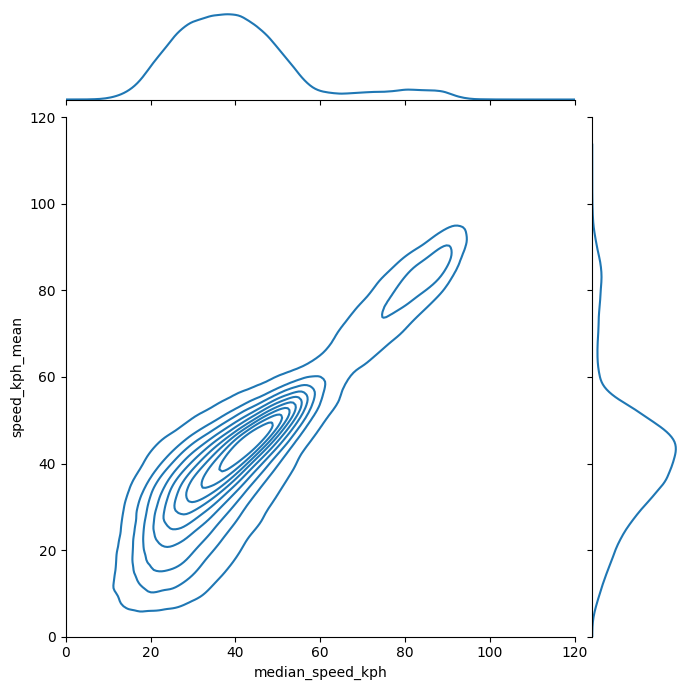

In [13]:
g = sns.jointplot(x="median_speed_kph", y="speed_kph_mean", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(0, 120),
                  height=7,
                  palette=sns.color_palette('Set2'))

# Stats of road segment matching  

In [14]:
def osm_color_palette():
    for c in ["#115f9a", "#22a7f0", 
                "#991f17", "#df8879", 
                "#48446e", "#9080ff", 
                "#a57c1b", "#ffb400"] + ["white"] * 99:
        yield c

In [15]:
# time label
ut_merged['date'] = pd.to_datetime(ut_merged[['year', 'month', 'day']])
ut_merged['date_hour'] = ut_merged['date'] + pd.to_timedelta(ut_merged['hour'], "hours")
ut_merged = ut_merged.sort_values(['date_hour', "sort_key"])

In [16]:
tspeeds_df['date'] = pd.to_datetime(tspeeds_df[['year', 'month', 'day']])
tspeeds_df['date_hour'] = tspeeds_df['date'] + pd.to_timedelta(tspeeds_df['hour'], "hours")
tspeeds_df = tspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
tspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in tspeeds_df["highway"]]
tspeeds_df = tspeeds_df.sort_values("sort_key")
tspeeds_df = tspeeds_df.sort_values(['date_hour', "sort_key"])

In [17]:
uspeeds_df['date'] = pd.to_datetime(uspeeds_df[['year', 'month', 'day']])
uspeeds_df['date_hour'] = uspeeds_df['date'] + pd.to_timedelta(uspeeds_df['hour'], "hours")
uspeeds_df = uspeeds_df.merge(gdf_edges, on=["u","v","gkey"])
uspeeds_df["sort_key"] = [highway_ordering.index(hw) for hw in uspeeds_df["highway"]]
uspeeds_df = uspeeds_df.sort_values("sort_key")
uspeeds_df = uspeeds_df.sort_values(['date_hour', "sort_key"])

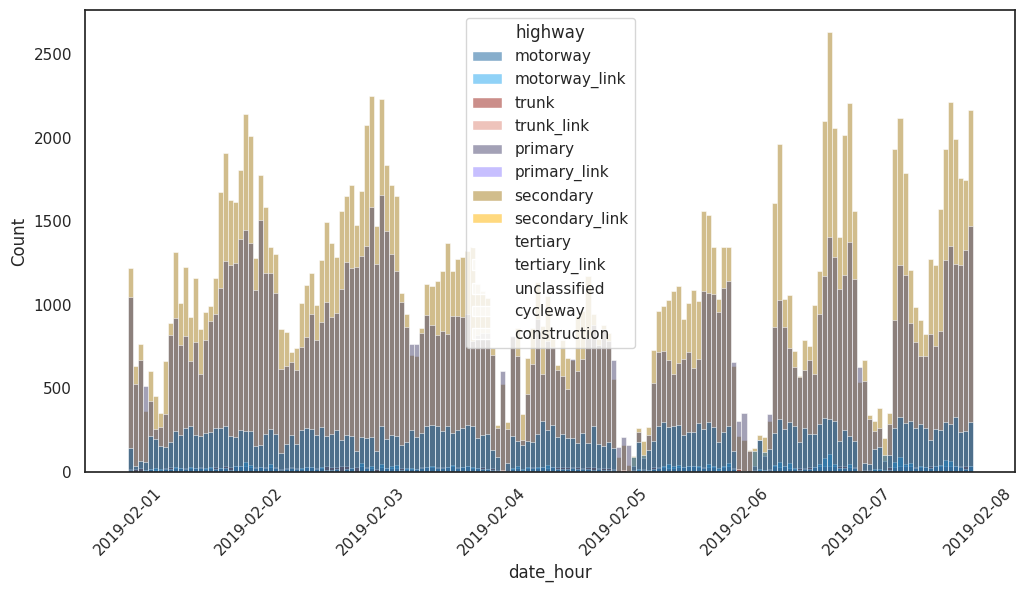

In [18]:
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style("white")

g = sns.histplot(data = ut_merged[[simplified_filter(hw) for hw in ut_merged["highway"]]],
                 x='date_hour', hue="highway", 
                 hue_order= [hw for hw in highway_ordering if simplified_filter(hw)], 
                 palette=osm_color_palette(),
                 bins= 7*24
                 )
plt.xticks(rotation=45)
plt.show()

In [19]:
tspeeds_hourly_count = tspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
uspeeds_hourly_count = uspeeds_df.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')
matched_hourly_count = ut_merged.groupby(['u', 'v', 'gkey', 'date_hour']).size().reset_index(name='count')

In [20]:
tspeeds_hourly_count['label'] = 'mcswts'
uspeeds_hourly_count['label'] = 'uber'
matched_hourly_count['label'] = 'matched'
hourly_count = pd.concat([tspeeds_hourly_count, uspeeds_hourly_count, matched_hourly_count])

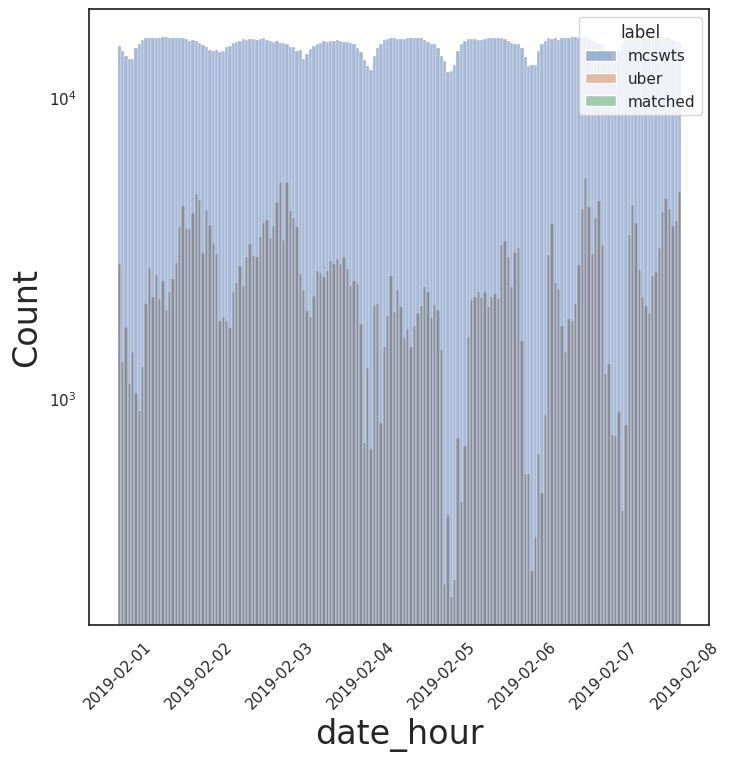

In [21]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count, x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24*7
)
plt.xticks(rotation=45)
plt.show()

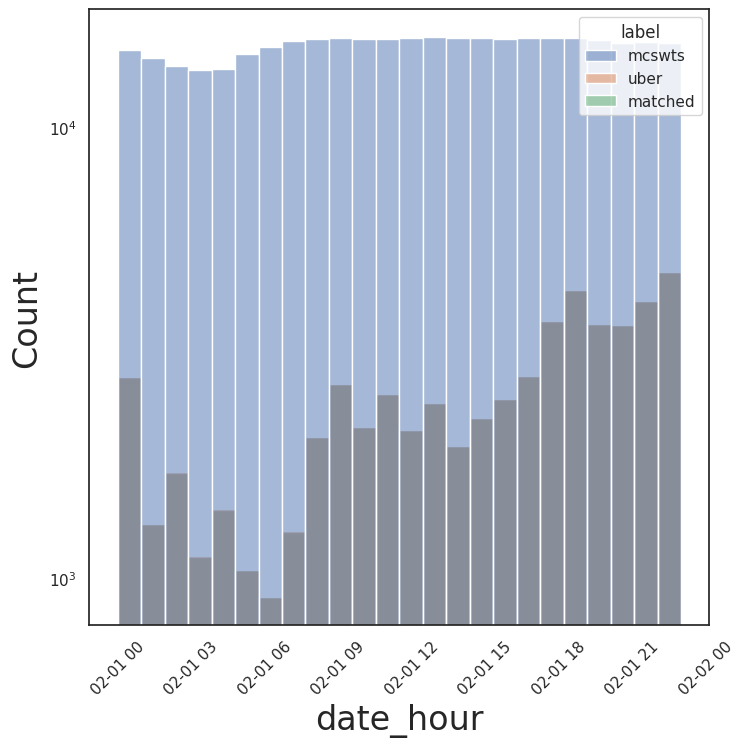

In [22]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("white")
plt.rcParams["axes.labelsize"] = 24

g = sns.histplot(
    hourly_count[(hourly_count['date_hour'] >= datetime(YEAR, MONTH, START_DAY)) & 
                (hourly_count['date_hour'] < datetime(YEAR, MONTH, START_DAY + 1))], x="date_hour", 
    hue="label", 
    log_scale=(False, True),
    bins=24
)
plt.xticks(rotation=45)
plt.show()

In [23]:
tspeeds_highway_hourly_count = tspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
uspeeds_highway_hourly_count = uspeeds_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])
matched_highway_hourly_count = matched_hourly_count.merge(gdf_edges[["u", "v", "gkey", "highway"]], 
                                                                    on=["u","v","gkey"])

In [24]:
tspeeds_highway_hourly_sum = tspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in tspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_41178/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/3769754942.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "d

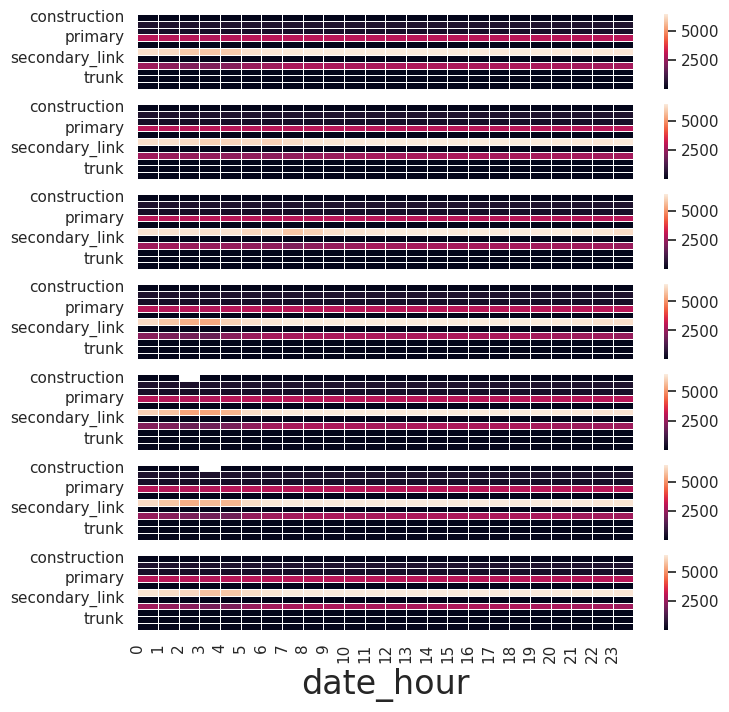

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    tspeeds_highway_hourly_sum_pivot = \
            tspeeds_highway_hourly_sum[(tspeeds_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (tspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(tspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [26]:
uspeeds_highway_hourly_sum = uspeeds_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in uspeeds_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_41178/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/82016574.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour

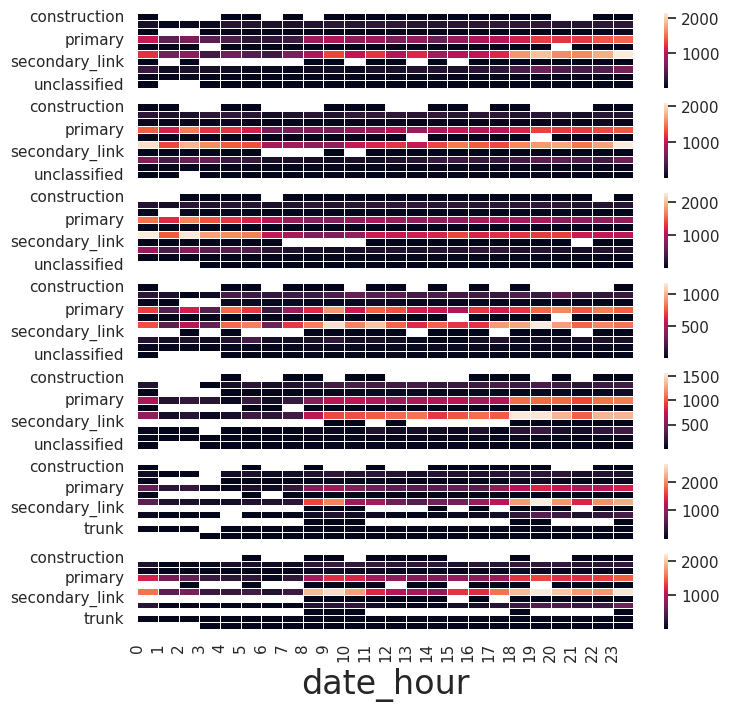

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    uspeeds_highway_hourly_sum_pivot = \
            uspeeds_highway_hourly_sum[(uspeeds_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (uspeeds_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(uspeeds_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

In [28]:
matched_highway_hourly_sum = matched_highway_hourly_count[[simplified_filter(hw) for hw 
                                                                in matched_highway_hourly_count["highway"]]]\
                            .groupby(["highway", "date_hour"]).agg({"count": sum})\
                            .reset_index()

/tmp/ipykernel_41178/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
/tmp/ipykernel_41178/4113610259.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "d

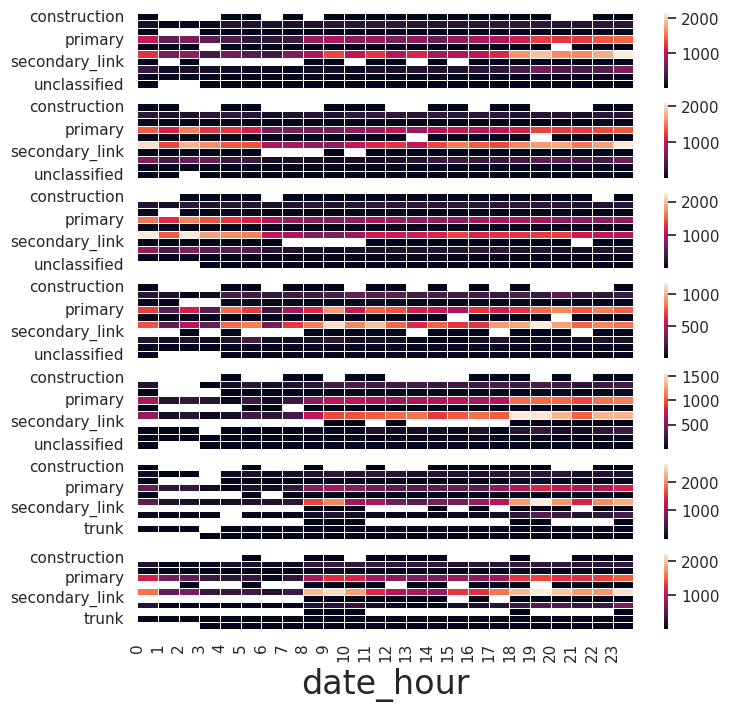

In [29]:
fig, axes = plt.subplots(nrows=7, ncols=1)

for idx, day in enumerate(range(START_DAY, END_DAY + 1)):
    ax = axes[idx]
    matched_highway_hourly_sum_pivot = \
            matched_highway_hourly_sum[(matched_highway_hourly_sum['date_hour'] >= datetime(YEAR, MONTH, day)) & 
            (matched_highway_hourly_sum['date_hour'] < datetime(YEAR, MONTH, day + 1))].pivot("highway", "date_hour", "count")
    g = sns.heatmap(matched_highway_hourly_sum_pivot, linewidths=.5, ax=ax)
    if idx < 6:
        g.set(xticklabels=[])
    else:
        g.set(xticks=range(24), xticklabels=[str(i) for i in range(24)])
    g.set(ylabel=None)

# Speed difference analysis

In [30]:
ut_merged['median_uber_diff'] = ut_merged['median_speed_kph'] - ut_merged['speed_kph_mean'] 

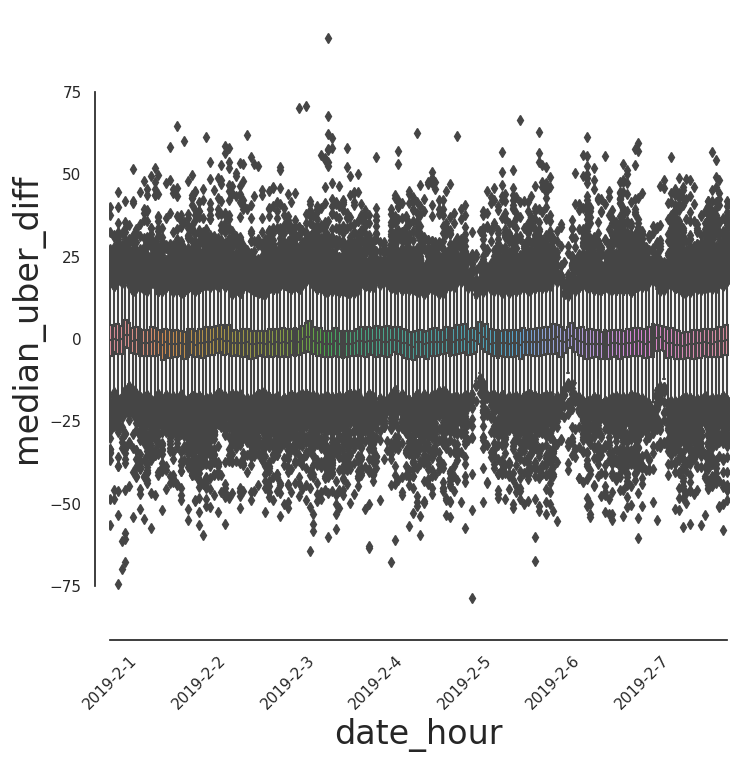

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

g = sns.boxplot(x="date_hour", y="median_uber_diff",
            data=ut_merged, ax = ax)
sns.despine(offset=10, trim=True)

ax.set_xticks(range(0, 24 * 7, 24))
ax.set_xticklabels([f"{YEAR}-{MONTH}-{i}" for i in range(START_DAY, END_DAY + 1)])
plt.xticks(rotation=45)

plt.show()

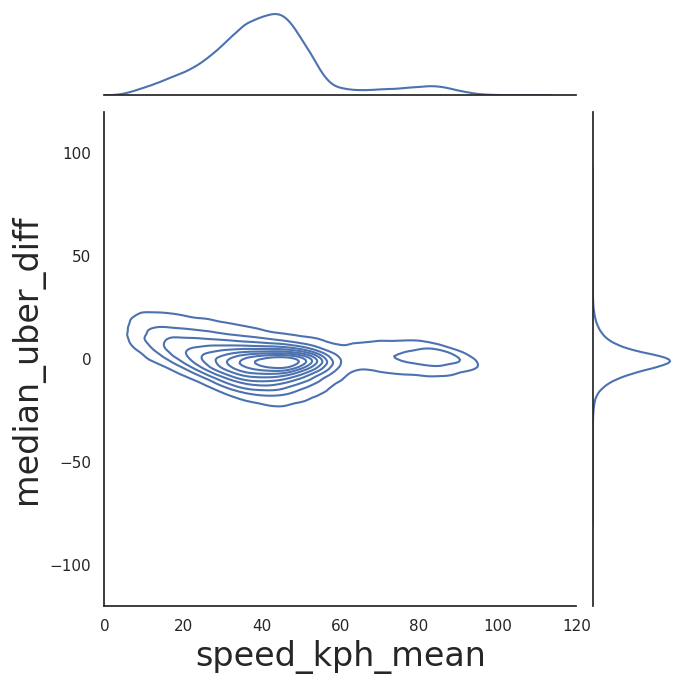

In [32]:
g = sns.jointplot(x="speed_kph_mean", y="median_uber_diff", data=ut_merged,
                  kind="kde", 
                  xlim=(0, 120), ylim=(-120, 120),
                  height=7, 
                  palette=sns.color_palette('Set2'))

## speed difference by time and road types

In [33]:
speed_diff_highway_hourly = ut_merged.groupby(["highway", "hour"])\
            .agg({'median_uber_diff': ['mean', 'count']}).reset_index()
speed_diff_highway_hourly.columns = ["highway", "hour", "speed_diff", "count"]

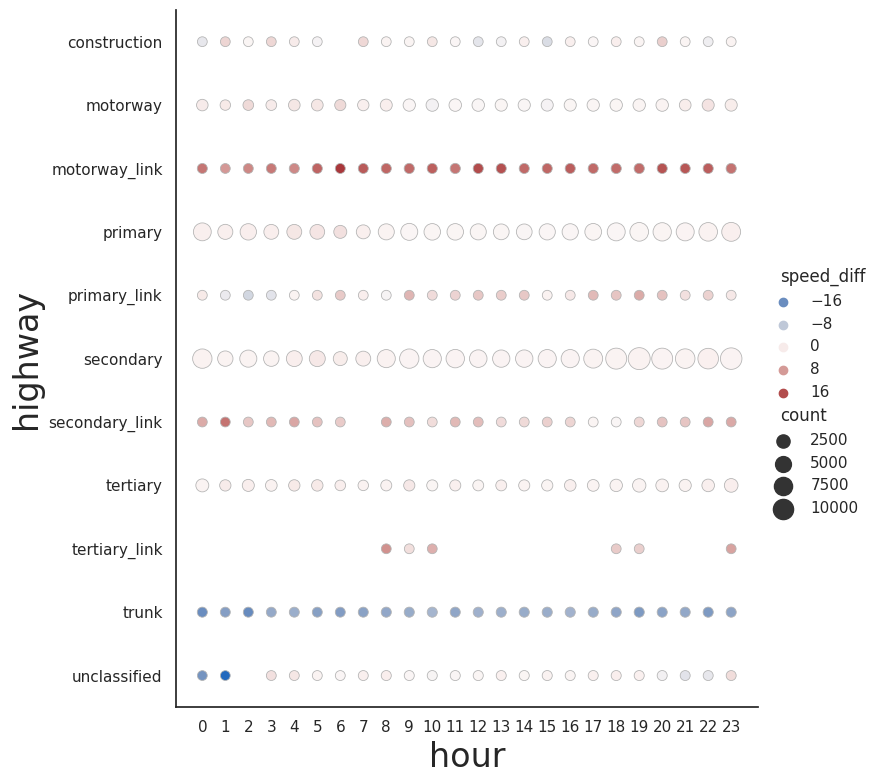

In [34]:
# here the hue refers to the mean of aggreagted speed diff by hour

g = sns.relplot(
    data=speed_diff_highway_hourly[[simplified_filter(hw) for hw in speed_diff_highway_hourly["highway"]]],
    x="hour", y="highway", hue="speed_diff", size="count",
    palette="vlag", edgecolor=".7",
    height=8, sizes=(50, 250), 
)
g.set(xticks= range(24))

## extreme difference by time

In [35]:
ut_merged['median_uber_diff'].quantile(q=0.975), ut_merged['median_uber_diff'].quantile(q=0.025)

(16.108041176470582, -16.19121176470588)

In [36]:
big_pos_div = ut_merged[ut_merged['median_uber_diff'] > ut_merged['median_uber_diff'].quantile(q=0.975)]
big_neg_div = ut_merged[ut_merged['median_uber_diff'] < ut_merged['median_uber_diff'].quantile(q=0.025)]

In [37]:
ut_hourly_matched = ut_merged.groupby('date_hour').size().reset_index(name='count')
big_pos_div_hourly = big_pos_div.groupby('date_hour').size().reset_index(name='count')
big_neg_div_hourly = big_neg_div.groupby('date_hour').size().reset_index(name='count')
hourly_matched = ut_hourly_matched.merge(big_pos_div_hourly, suffixes=["","_pos"], on='date_hour')\
                                    .merge(big_neg_div_hourly, suffixes=["","_neg"], on='date_hour')

In [38]:
hourly_matched['pos_prop'] = hourly_matched['count_pos'] / hourly_matched['count']
hourly_matched['neg_prop'] = hourly_matched['count_neg'] / hourly_matched['count']

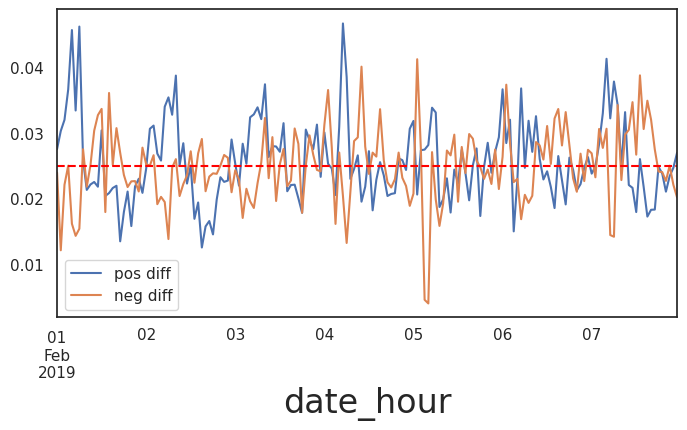

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))

g = hourly_matched.plot(x='date_hour', y="pos_prop", ax=ax, label='pos diff')
g = hourly_matched.plot(x='date_hour', y="neg_prop", ax=ax, label='neg diff')

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

In [40]:
hourly_matched['hour'] = hourly_matched['date_hour'].dt.hour

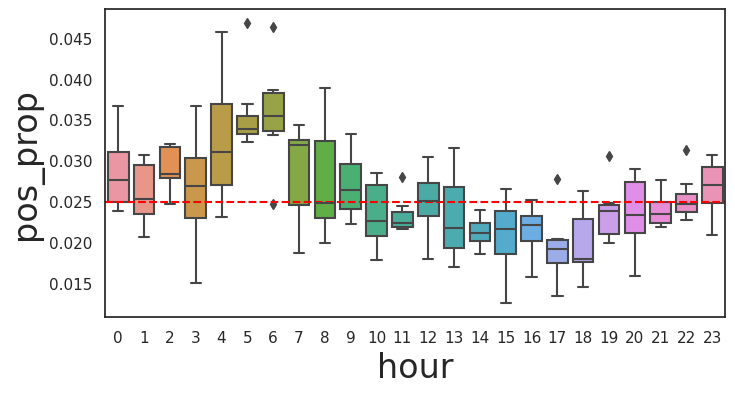

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))

g = sns.boxplot(hourly_matched, x= 'hour', y="pos_prop", ax=ax)

plt.axhline(0.025, color='red', linestyle='--')
plt.show()

Are there segments always having big speed difference?

In [42]:
pos_seg_counts = big_pos_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div.groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [43]:
pos_seg_counts['date_hour'].describe()

count    2260.000000
mean        4.510177
std         9.099878
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       112.000000
Name: date_hour, dtype: float64

In [44]:
neg_seg_counts['date_hour'].describe()

count    2356.000000
mean        4.326401
std        11.472334
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       147.000000
Name: date_hour, dtype: float64

In [45]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

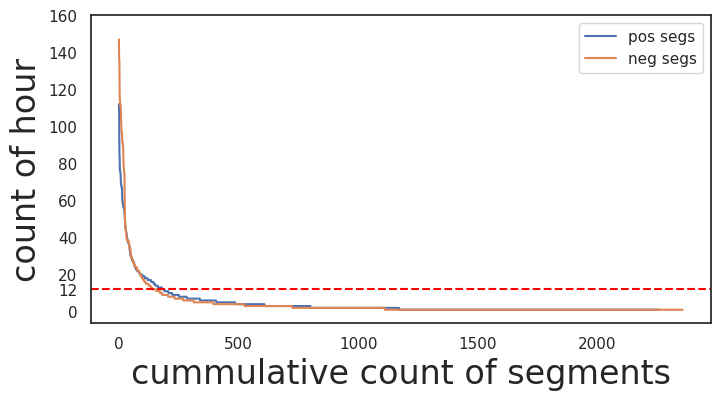

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
ax.set_ylabel('count of hour')
ax.set_xlabel('cummulative count of segments')

ax.set_yticks(list(range(0, 170, 20)) + [12])

plt.axhline(12, color='red', linestyle='--')
plt.legend()
plt.show()

In [47]:
pos_seg_counts.sort_values("date_hour", ascending=False)

,u,v,gkey,date_hour
1065,428225994,2248585708,428225994_2248585708_292522742,112
1555,2248585708,2248585334,2248585708_2248585334_215425318,106
1066,428225996,428225994,428225996_428225994_38232090,86
1888,3513425993,29219441,3513425993_29219441_4612964,83
1554,2248585683,1641539229,2248585683_1641539229_215425304,76
...,...,...,...,...
498,27555213,4946804981,27555213_4946804981_128276155,1
499,27555214,27555213,27555214_27555213_75066614,1
524,28095595,518469425,28095595_518469425_155605281,1
523,28095233,331527049,28095233_331527049_10996029,1


In [48]:
# worst case 

s_u, s_v, s_gkey, s_dh = pos_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_pos_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [49]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)

s_map

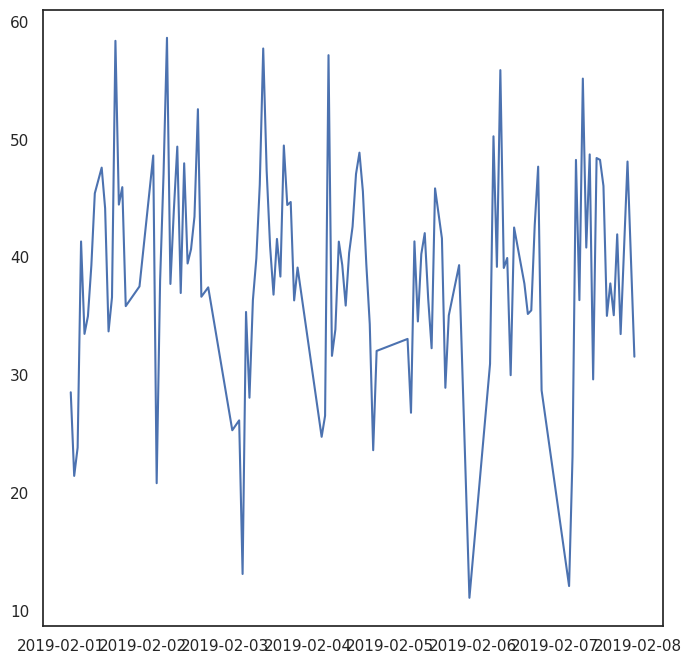

In [50]:
plt.plot(sample_big_pos_div["date_hour"], sample_big_pos_div["median_uber_diff"])

In [51]:
# worst case 

s_u, s_v, s_gkey, s_dh = neg_seg_counts.sort_values("date_hour", ascending=False).iloc[0]

sample_big_neg_div = ut_merged[(ut_merged['u'] == s_u) & (ut_merged['v'] == s_v) 
            & (ut_merged['gkey'] == s_gkey)] 

s_seg = gdf_edges[(gdf_edges['u'] == s_u) & (gdf_edges['v'] == s_v) 
            & (gdf_edges['gkey'] == s_gkey)]

In [52]:
s_map = folium.Map(location = (s_seg['geometry'].centroid.y, 
                                s_seg['geometry'].centroid.x), zoom_start = 16)
s_j = s_seg['geometry'].to_json()
s_j = folium.GeoJson(data=s_j, style_function=lambda x: {'color': 'red'})
s_j.add_to(s_map)
s_map

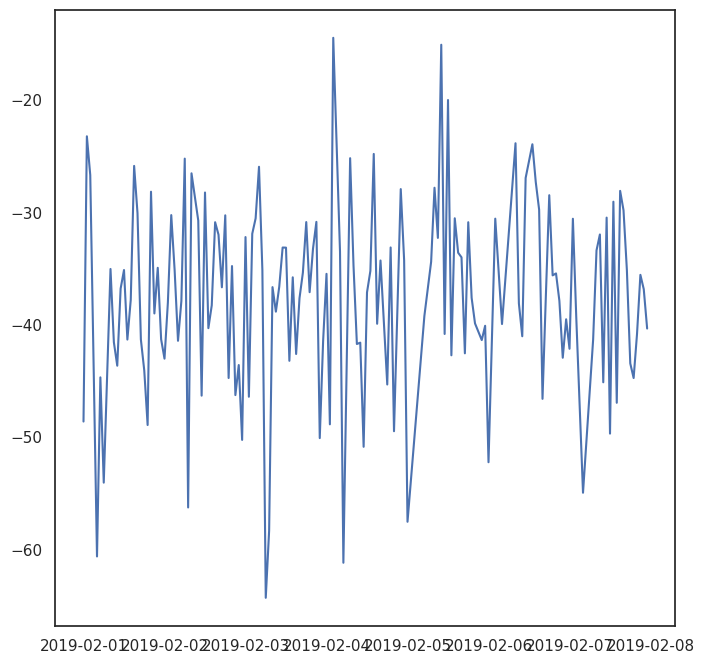

In [53]:
plt.plot(sample_big_neg_div["date_hour"], sample_big_neg_div["median_uber_diff"])

In [54]:
pos_seg_counts[pos_seg_counts["date_hour"] > 12].shape, neg_seg_counts[neg_seg_counts["date_hour"] > 12].shape

((180, 4), (139, 4))

In [55]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(327, 5) (2260, 4) (2356, 4)


In [56]:
# no case with consistant big negative and positive values

pos_neg_seg_counts[(pos_neg_seg_counts["date_hour_pos"] > 12) & (pos_neg_seg_counts["date_hour_neg"]) > 12].shape

(0, 5)

In [57]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        < pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        >= pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [58]:
pos_neg_seg_counts['overlap_hour'].max()

5.0

In [59]:
seg_highway_counts = gdf_edges.groupby('highway').size().reset_index(name='count')

In [60]:
# It is # of segments
pos_seg_highway_counts = pos_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [61]:
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

In [62]:
neg_seg_highway_counts = neg_seg_counts.merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')

In [63]:
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

In [64]:
pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

In [65]:
pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

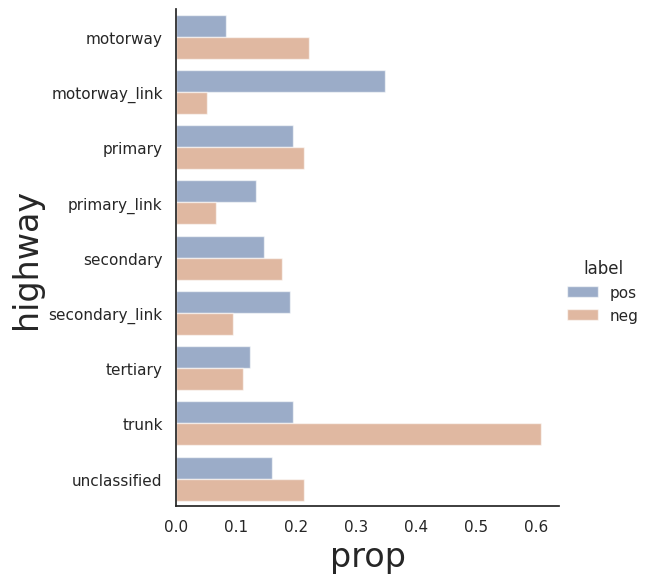

In [66]:
g = sns.catplot(
    data= pos_neg_highway[[simplified_filter(hw) for hw 
                            in pos_neg_highway["highway"]]], 
    kind="bar",
    x="prop", y="highway", hue="label",
    # alette="dark", 
    alpha=.6, height=6
)

In [67]:
# stats of segs with hour > 12
pos_seg_highway_counts = pos_seg_counts[pos_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
pos_seg_highway_counts = pos_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
pos_seg_highway_counts['prop'] = pos_seg_highway_counts['count_pos'] / pos_seg_highway_counts['count_all']

neg_seg_highway_counts = neg_seg_counts[neg_seg_counts['date_hour'] > 12].merge(gdf_edges, on=['u', 'v', 'gkey'], 
                                            how='left').groupby('highway').size().reset_index(name='count')
neg_seg_highway_counts = neg_seg_highway_counts.merge(seg_highway_counts, on='highway', 
                                                        suffixes=['_pos', '_all'])
neg_seg_highway_counts['prop'] = neg_seg_highway_counts['count_pos'] / neg_seg_highway_counts['count_all']

pos_seg_highway_counts['label'] = 'pos'
neg_seg_highway_counts['label'] = 'neg'

pos_neg_highway = pd.concat([pos_seg_highway_counts, neg_seg_highway_counts], axis=0)

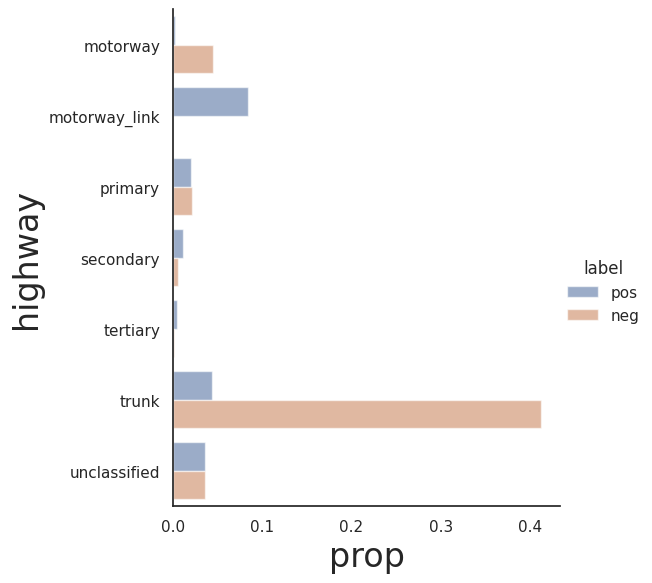

In [68]:
g = sns.catplot(
    data= pos_neg_highway[[simplified_filter(hw) for hw 
                            in pos_neg_highway["highway"]]], 
    kind="bar",
    x="prop", y="highway", hue="label",
    # alette="dark", 
    alpha=.6, height=6
)

Are there segments always having big speed difference within day-time?

In [69]:
DAYTIME_START_HOUR=8
DAYTIME_END_HOUR=18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [70]:
pos_seg_counts = big_pos_div[(big_pos_div.hour >= DAYTIME_START_HOUR) & (big_pos_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()
neg_seg_counts = big_neg_div[(big_neg_div.hour >= DAYTIME_START_HOUR) & (big_neg_div.hour < DAYTIME_END_HOUR)]\
                        .groupby(["u", "v", "gkey"]).\
                        agg({'date_hour': 'count'}).reset_index()

In [71]:
pos_seg_counts['date_hour'].describe()

count    1119.000000
mean        3.445934
std         6.491392
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        66.000000
Name: date_hour, dtype: float64

In [72]:
neg_seg_counts['date_hour'].describe()

count    1358.000000
mean        3.359352
std         6.942369
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        68.000000
Name: date_hour, dtype: float64

In [73]:
pos_seg_counts = pos_seg_counts.sort_values("date_hour", ascending=False)
neg_seg_counts = neg_seg_counts.sort_values("date_hour", ascending=False)

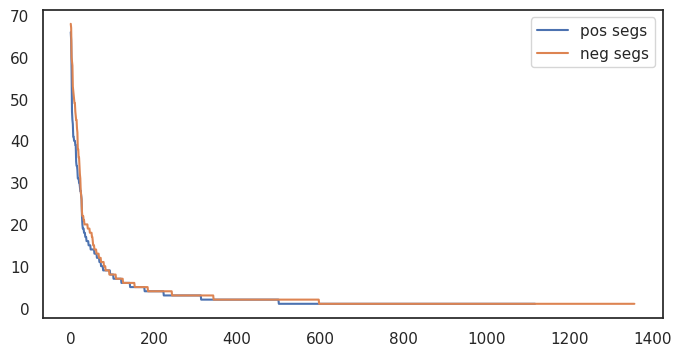

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))

g = ax.plot(range(pos_seg_counts.shape[0]), pos_seg_counts.date_hour, label='pos segs')
g = ax.plot(range(neg_seg_counts.shape[0]), neg_seg_counts.date_hour, label='neg segs')
plt.legend()
plt.show()

In [75]:
print(pos_seg_counts[pos_seg_counts["date_hour"] > DAYTIME_HOURS].shape, 
neg_seg_counts[neg_seg_counts["date_hour"] > DAYTIME_HOURS].shape)

(73, 4) (80, 4)


In [76]:
pos_neg_seg_counts = pos_seg_counts.merge(neg_seg_counts, on=["u", "v", "gkey"], how='inner', suffixes=["_pos","_neg"])
print(pos_neg_seg_counts.shape, pos_seg_counts.shape, neg_seg_counts.shape)

(78, 5) (1119, 4) (1358, 4)


In [77]:
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        <= pos_neg_seg_counts['date_hour_neg']]['date_hour_pos']
pos_neg_seg_counts['overlap_hour'] = pos_neg_seg_counts[pos_neg_seg_counts['date_hour_pos'] 
                                                        > pos_neg_seg_counts['date_hour_neg']]['date_hour_neg']

In [78]:
pos_neg_seg_counts['overlap_hour'].max()

4.0

In [79]:
pos_neg_seg_counts.sort_values('overlap_hour', ascending = False)

,u,v,gkey,date_hour_pos,date_hour_neg,overlap_hour
2,3784870573,566160398,3784870573_566160398_375097991,6,4,4.0
0,267400443,26871101,267400443_26871101_4484050,15,2,2.0
1,1729388156,26869633,1729388156_26869633_160971198,9,2,2.0
11,4516959817,5181544680,4516959817_5181544680_32954835,2,1,1.0
21,2467429059,295706299,2467429059_295706299_431356088,2,1,1.0
...,...,...,...,...,...,...
73,1020330221,26836035,1020330221_26836035_4388869,1,1,NaN
74,28794056,1840309863,28794056_1840309863_4484427,1,2,NaN
75,28302161,498817385,28302161_498817385_42732321,1,1,NaN
76,1635318723,1635318763,1635318723_1635318763_195411606,1,3,NaN
